In [1]:
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import time
from gpflow.utilities import print_summary

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [9]:
with open('results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [81]:
x_subsample = np.concatenate((x.final.b_nn_corrected[::30][500:], x.final.a_nn_corrected[::10000]),axis=0)
time_subsample = np.concatenate((x.base_signals.t_b_nn[::30][500:], x.base_signals.t_a_nn[::10000]),axis=0)

mean = np.mean(np.concatenate((x.final.b_nn_corrected, x.final.a_nn_corrected), axis=0))
std = np.std(np.concatenate((x.final.b_nn_corrected, x.final.a_nn_corrected), axis=0))

mean_t = np.mean(np.concatenate((x.base_signals.t_b_nn, x.base_signals.t_a_nn), axis=0))
std_t = np.std(np.concatenate((x.base_signals.t_b_nn, x.base_signals.t_a_nn), axis=0))

X, Y = (time_subsample - mean_t)/std_t, (x_subsample - mean)/std

X, Y = X[np.greater_equal(Y, -2)],  Y[np.greater_equal(Y, -2)]
X, Y = X[np.less_equal(Y, 2)],  Y[np.less_equal(Y, 2)]

X, Y = X.reshape(-1,1), Y.reshape(-1,1)

# mean = np.mean(x_subsample)

# X, Y = time_subsample, x_subsample - mean
# X, Y = X.reshape(-1,1), Y.reshape(-1,1)

N = np.size(X)

In [82]:
Y.shape

(1964, 1)

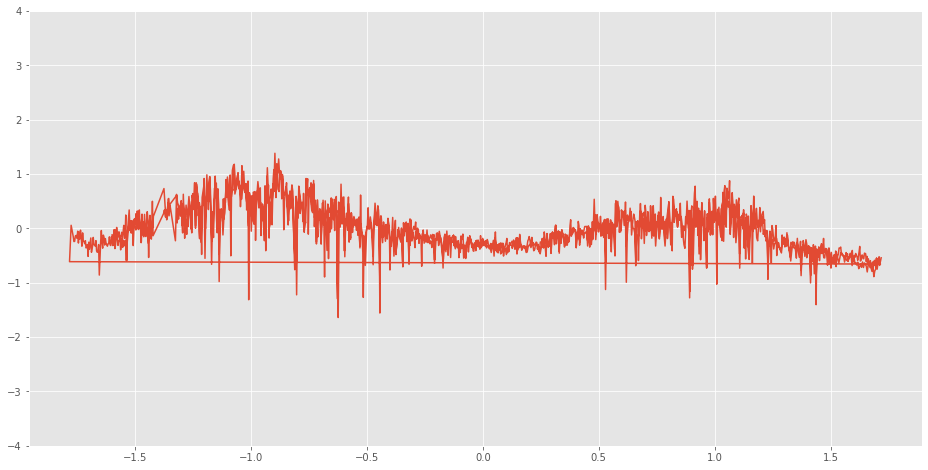

In [83]:
plt.figure(5, figsize=(16, 8))
plt.ylim(-4, 4)
plt.plot(X, Y)

In [84]:
number_of_inducing_locations = 200
interval = (np.min(X), np.max(X))
time_indicies=np.linspace(interval[0], interval[1], number_of_inducing_locations)

In [85]:
def find_nearest(array, values):
    indices = np.zeros(values.shape)
    for index, value in enumerate(values):
        indices[index] = np.abs(array - value).argmin()
    return indices

In [86]:
np.size(find_nearest(X, time_indicies).astype(int))

200

In [95]:
indices = find_nearest(X, time_indicies).astype(int)

kernel = gpflow.kernels.Sum([gpflow.kernels.Matern12(),gpflow.kernels.White()])
kernel = gpflow.kernels.White()

Z = X[indices].copy()  # Initialise inducing locations
M = np.size(Z)
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
#m.kernel.kernels[0].lengthscale.assign(0.15)
# m.kernel.kernels[0].lengthscale.assign(0.263)
#m.kernel.kernels[0].variance.assign(1)
#gpflow.utilities.set_trainable(m.kernel.kernels[0].variance, False)
gpflow.utilities.set_trainable(m.inducing_variable, False)
print_summary(m)

name                      class      transform       trainable    shape          dtype    value
------------------------  ---------  --------------  -----------  -------------  -------  ----------------
SVGP.kernel.variance      Parameter  Softplus        True         ()             float64  1.0
SVGP.likelihood.variance  Parameter  Softplus        True         ()             float64  1.0
SVGP.inducing_variable.Z  Parameter                  False        (200, 1)       float64  [[-1.78378559...
SVGP.q_mu                 Parameter                  True         (200, 1)       float64  [[0....
SVGP.q_sqrt               Parameter  FillTriangular  True         (1, 200, 200)  float64  [[[1., 0., 0....


In [96]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [97]:
%%timeit
log_likelihood(X, Y)

12.6 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
log_likelihood(X, Y)

<tf.Tensor: id=6284, shape=(), dtype=float64, numpy=-2948.1177813081367>

In [73]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

In [64]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N, seed=0)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(X, Y).numpy()

In [41]:
%%timeit
log_likelihood(*next(train_it))

2.72 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
evals = [log_likelihood(*minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: -0.37193037369661397


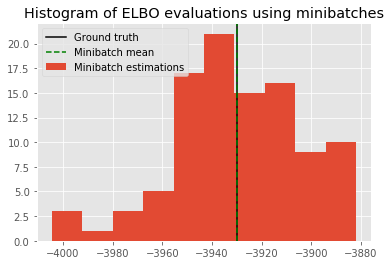

In [43]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [44]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(*minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

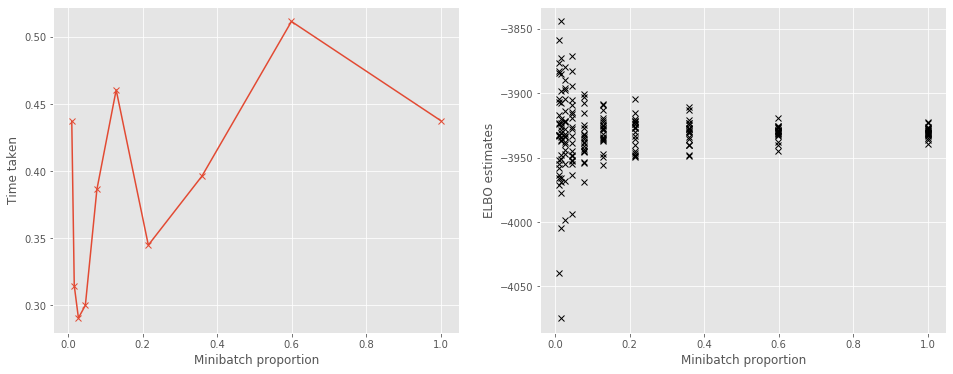

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

(200, 1)


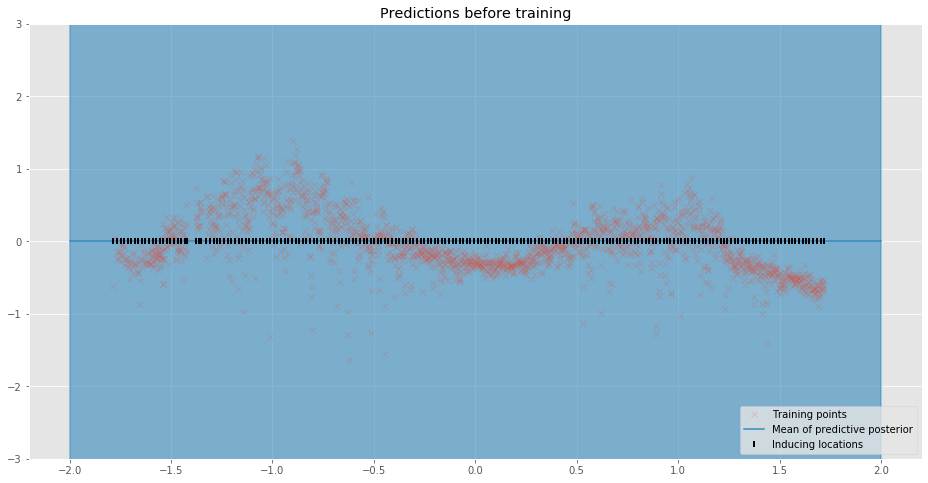

In [46]:
def plot(title=''):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    pX = np.linspace(-2, 2, 100)[:, None] # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    print(Z.shape)
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')
    plt.ylim(-3, 3)

plot(title="Predictions before training")

In [47]:
minibatch_size = 100

# We turn of training for inducing point locations

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimiser
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 1000 == 0:
            print('We are on the step {}'.format(step))
            print("Step:\t{:<30}ELBO:\t{:>10}".format(step, elbo.numpy()))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

We are on the step 0
Step:	0                             ELBO:	-3918.17938530581
We are on the step 1000
Step:	1000                          ELBO:	-2340.8189456175223
We are on the step 2000
Step:	2000                          ELBO:	-1631.6628027577553
We are on the step 3000
Step:	3000                          ELBO:	-995.2105338769246
We are on the step 4000
Step:	4000                          ELBO:	-723.9714072508802
We are on the step 5000
Step:	5000                          ELBO:	-1141.317212144985
We are on the step 6000
Step:	6000                          ELBO:	-440.8200401992749
We are on the step 7000
Step:	7000                          ELBO:	-287.95104249735516
71.67767095565796


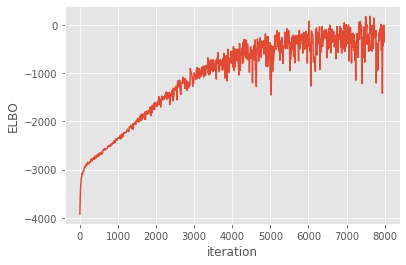

In [48]:
start = time.time()

maxiter = ci_niter(8000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

end = time.time()
print(end - start)

(-100000, 10000)

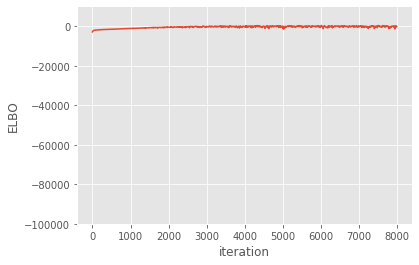

In [212]:
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.ylim(-100000, 10000)

(200, 1)


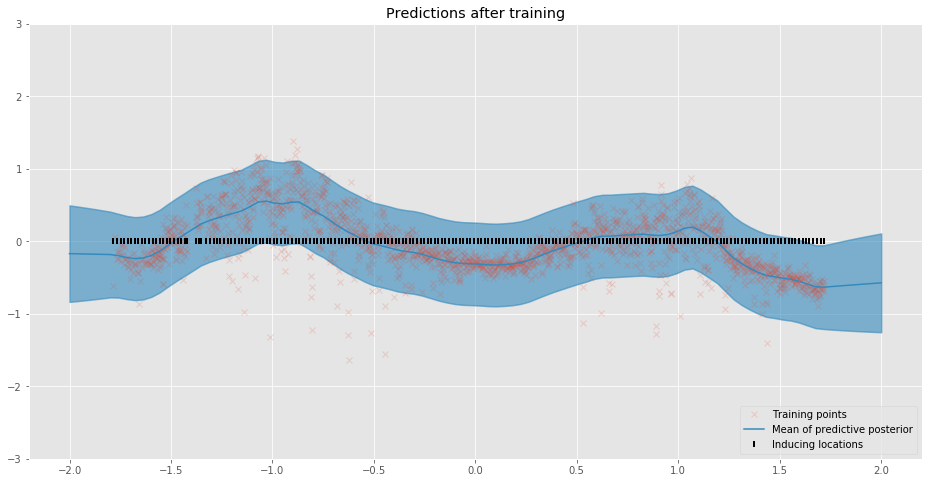

In [49]:
plot("Predictions after training")

In [50]:
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  0.1857252642903542
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  2.8371428504568112
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  0.0038660609689445367
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  0.07468508212882967
SVGP.inducing_variable.Z            Parameter                  False        (200, 1)       float64  [[-1.78378559...
SVGP.q_mu                           Parameter                  True         (200, 1)       float64  [[-0.38392631...
SVGP.q_sqrt                

# Kernel Design

In [ ]:
from gpflow.utilities import print_summary, positive
from gpflow.utilities.ops import square_distance

In [10]:
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import time
import pickle
from gpflow.utilities import print_summary

with open('./results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [11]:
x_subsample_a = x.final.a_nn_corrected[::300]
time_subsample_a = x.base_signals.t_a_nn[::300]

x_subsample_b = x.final.b_nn_corrected[:]
time_subsample_b = x.base_signals.t_b_nn[:]

mean = np.mean(np.concatenate((x.final.b_nn_corrected, x.final.a_nn_corrected), axis=0))
std = np.std(np.concatenate((x.final.b_nn_corrected, x.final.a_nn_corrected), axis=0))

mean_t = np.mean(np.concatenate((x.base_signals.t_b_nn, x.base_signals.t_a_nn), axis=0))
std_t = np.std(np.concatenate((x.base_signals.t_b_nn, x.base_signals.t_a_nn), axis=0))

X_a, Y_a = (time_subsample_a - mean_t)/std_t, (x_subsample_a - mean)/std
X_a, Y_a = X_a[np.greater_equal(Y_a, -4)],  Y_a[np.greater_equal(Y_a, -4)]
X_a, Y_a = X_a[np.less_equal(Y_a, 4)],  Y_a[np.less_equal(Y_a, 4)]
X_a = np.stack((X_a, np.ones(X_a.shape)))

X_b, Y_b = (time_subsample_b - mean_t)/std_t, (x_subsample_b - mean)/std
X_b, Y_b = X_b[np.greater_equal(Y_b, -4)],  Y_b[np.greater_equal(Y_b, -4)]
X_b, Y_b = X_b[np.less_equal(Y_b, 4)],  Y_b[np.less_equal(Y_b, 4)]
X_b = np.stack((X_b, np.zeros(X_b.shape)))

print(X_a.shape, Y_a.shape, X_b.shape, Y_b.shape)

(2, 38709) (38709,) (2, 39090) (39090,)


In [23]:
x.final.a_nn_corrected.shape[0] // x_subsample_b.shape[0]

297

In [34]:
X = np.transpose(np.concatenate((X_a, X_b), axis=1)).reshape(-1, 2)
Y = np.transpose(np.concatenate((Y_a, Y_b), axis=0)).reshape(-1, 1)

print(X.shape, Y.shape)
N = X.shape[0]
print(N)


(77799, 2) (77799, 1)
77799


-0.11418676253081587 -0.31637727271965754


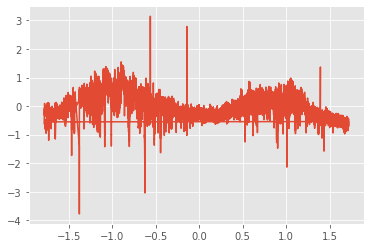

In [35]:
print(np.mean(Y), np.mean(X[:,0]))
plt.plot(X[:,0], Y)

In [9]:
import sys

In [8]:
class VirgoWhiteKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0,1])
        self.variance_a = gpflow.Parameter(1.0, transform=positive())
        self.variance_b = gpflow.Parameter(1.0, transform=positive())
        
    def K(self, X, X2=None, presliced=None):
        if X2 is None:
            d_a = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
            d_b = tf.fill((X.shape[0], ), tf.squeeze(self.variance_b))
            indices_a = tf.cast(tf.equal(X[:,1], 0), dtype=tf.float64)
            indices_b = tf.cast(tf.equal(X[:,1], 1), dtype=tf.float64)
            a=tf.linalg.diag(tf.multiply(d_a, indices_a) + tf.multiply(d_b, indices_b))
            #print(a.shape)
            return a
        else:
            shape = [X.shape[0], X2.shape[0]]
            #print(shape)
            return tf.zeros(shape, dtype=X.dtype)

    def K_diag(self, X, presliced=None):
        d_a = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
        d_b = tf.fill((X.shape[0], ), tf.squeeze(self.variance_b))
        indices_a = tf.cast(tf.equal(X[:,1], 0), dtype=tf.float64)
        indices_b = tf.cast(tf.equal(X[:,1], 1), dtype=tf.float64)
        a = tf.multiply(d_a, indices_a) + tf.multiply(d_b, indices_b)
        #print(a.shape)
        return a

In [9]:
class VirgoMatern32Kernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0, 1])
        self.variance = gpflow.Parameter(1.0, transform=positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
        
    def scaled_squared_euclid_dist(self, X, X2=None):
        """
        Returns ||(X - X2ᵀ) / ℓ||² i.e. squared L2-norm.
        """
        X_scaled = X / self.lengthscale
        X2_scaled = X2 / self.lengthscale if X2 is not None else X2
        return square_distance(X_scaled, X2_scaled)

    def K(self, X, X2=None, presliced=False):      
        if not presliced:
            X, X2 = self.slice(X, X2)
        X = tf.reshape(X[:, 0], [-1, 1])
        X2 = tf.reshape(X2[:, 0], [-1, 1])
        r2 = self.scaled_squared_euclid_dist(X, X2)
        k = self.K_r2(r2)
        return k

    def K_diag(self, X, presliced=False):
        k_diag = tf.fill((X.shape[0], ), tf.squeeze(self.variance))
        return k_diag
        
    def K_r(self, r):
        sqrt3 = np.sqrt(3.)
        return self.variance * (1. + sqrt3 * r) * tf.exp(-sqrt3 * r)
    
    def K_r2(self, r2):
        """
        Returns the kernel evaluated on r² (`r2`), which is the squared scaled Euclidean distance
        Should operate element-wise on r²
        """
        if hasattr(self, "K_r"):
            # Clipping around the (single) float precision which is ~1e-45.
            r = tf.sqrt(tf.maximum(r2, 1e-40))
            return self.K_r(r)  # pylint: disable=no-member

        raise NotImplementedError

In [36]:
class VirgoMatern12Kernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0, 1])
        self.variance = gpflow.Parameter(1.0, transform=positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
        
    def scaled_squared_euclid_dist(self, X, X2=None):
        """
        Returns ||(X - X2ᵀ) / ℓ||² i.e. squared L2-norm.
        """
        X_scaled = X / self.lengthscale
        X2_scaled = X2 / self.lengthscale if X2 is not None else X2
        return square_distance(X_scaled, X2_scaled)

    def K(self, X, X2=None, presliced=False):      
        if not presliced:
            X, X2 = self.slice(X, X2)
        X = tf.reshape(X[:, 0], [-1, 1])
        X2 = tf.reshape(X2[:, 0], [-1, 1])
        r2 = self.scaled_squared_euclid_dist(X, X2)
        k = self.K_r2(r2)
        return k

    def K_diag(self, X, presliced=False):
        k_diag = tf.fill((X.shape[0], ), tf.squeeze(self.variance))
        return k_diag
            
    def K_r(self, r):
        return self.variance * tf.exp(-r)
    
    def K_r2(self, r2):
        """
        Returns the kernel evaluated on r² (`r2`), which is the squared scaled Euclidean distance
        Should operate element-wise on r²
        """
        if hasattr(self, "K_r"):
            # Clipping around the (single) float precision which is ~1e-45.
            r = tf.sqrt(tf.maximum(r2, 1e-40))
            return self.K_r(r)  # pylint: disable=no-member

        raise NotImplementedError

# Training Gaussian Processes on both A) and B) signal

In [37]:
number_of_induced_points=200
interval = (np.min(X[:,0]), np.max(X[:,0]))
time_indicies=np.linspace(interval[0], interval[1], number_of_induced_points)

In [13]:
#time_indicies

In [38]:
def find_nearest(array, values):
    indices = np.zeros(values.shape)
    for index, value in enumerate(values):
        indices[index] = np.abs(array - value).argmin()
    return indices

In [39]:
indices = find_nearest(X[:,0], time_indicies).astype(int)
Z = X[indices,:]

In [40]:
Z.shape

(200, 2)

In [41]:
kernel = gpflow.kernels.Sum([VirgoMatern12Kernel(), VirgoWhiteKernel()])
#kernel = VirgoMatern32Kernel()
#kernel = gpflow.kernels.Sum([gpflow.kernels.Matern12(active_dims=[0]), VirgoWhiteKernel()])
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
#m.kernel.variance.assign(2.0)
#m.kernel.kernels[0].lengthscale.assign(0.1)
# m.kernel.kernels[0].variance.assign(0.7700127464231572)
# m.kernel.kernels[1].variance_a.assign(0.02)
# m.kernel.kernels[1].variance_b.assign(0.010844863099046444)

gpflow.utilities.set_trainable(m.inducing_variable, False)
#gpflow.utilities.set_trainable(m.kernel.kernels[0].lengthscale, False)

print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  --------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[1].variance_a   Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[1].variance_b   Parameter  Softplus        True         ()             float64  1.0
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  1.0
SVGP.inducing_variable.Z            Parameter                  False        (200, 2)       float64  [[-1.78378559, 1....
SVGP.q_mu                           Parameter                  True         (200, 1)       float64  [[0....
SVGP.q_sqrt             

In [18]:
m.log_likelihood

<bound method SVGP.log_likelihood of <gpflow.models.svgp.SVGP object at 0x1a69f41450>>

In [42]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [20]:
%%timeit
log_likelihood(X, Y)

555 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
log_likelihood(X, Y)

<tf.Tensor: id=773, shape=(), dtype=float64, numpy=-116430.0597459224>

In [175]:
#m.trainable_variables

In [176]:
m.kernel.kernels[1].variance_a

<tf.Tensor: id=49802, shape=(), dtype=float64, numpy=1.0>

In [43]:
minibatch_size = 200

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

In [25]:
minibatch_size = 200

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(X, Y).numpy()

In [178]:
%%timeit
log_likelihood(*next(train_it))

3.63 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [179]:
evals = [log_likelihood(*minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: 153.6257664621371


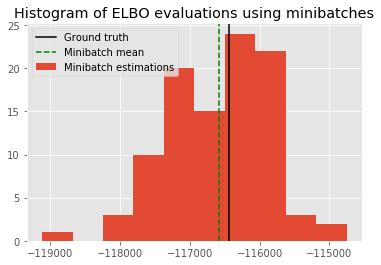

In [180]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [181]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(*minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

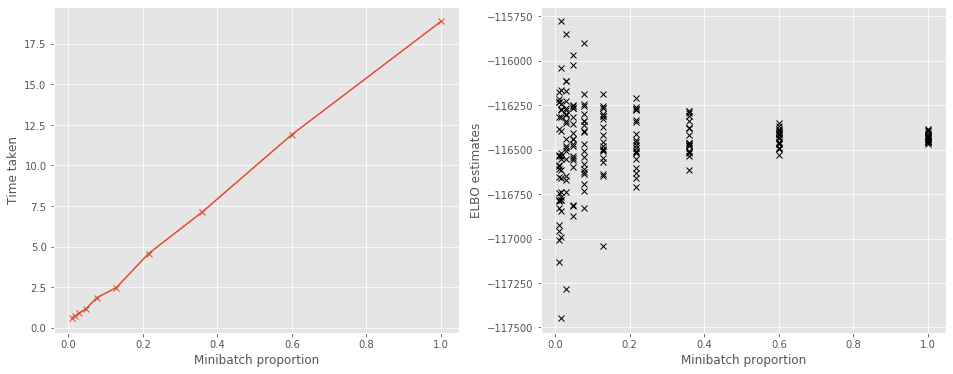

In [182]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

(200, 2)


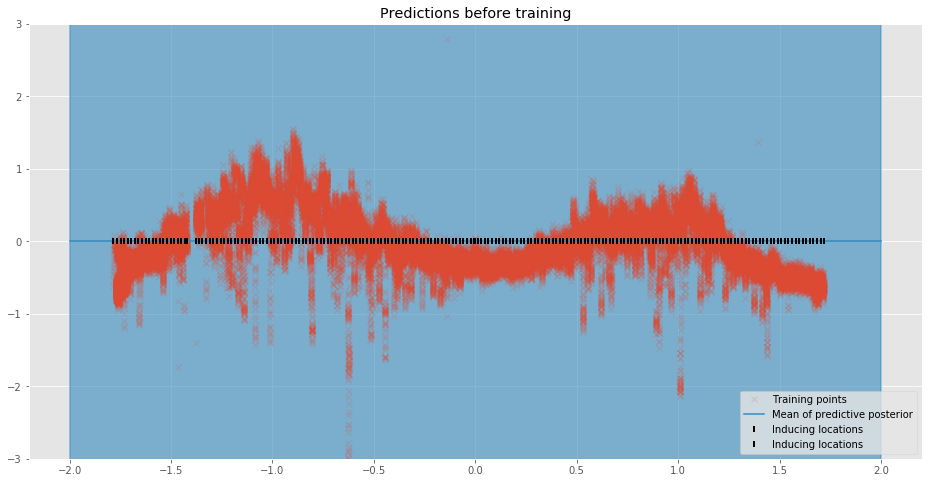

In [44]:
def plot(title=''):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    pX = np.linspace(-2, 2, 100)  # Test locations
    pX = np.transpose(np.stack((pX, 0*np.ones(100))))
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X[:,0], Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX[:,0], pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    print(Z.shape)
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')
    plt.ylim(-3, 3)

plot(title="Predictions before training")

In [27]:
print(m.inducing_variable.trainable_variables)

()


In [45]:
minibatch_size = 200

# We turn of training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimiser
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 1000 == 0:
            print('We are on the step {}'.format(step))
            print("Step:\t{:<30}ELBO:\t{:>10}".format(step, elbo.numpy()))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

We are on the step 0
Step:	0                             ELBO:	-156277.759353761
We are on the step 1000
Step:	1000                          ELBO:	-93278.59296697355
We are on the step 2000
Step:	2000                          ELBO:	-64405.98531902628
We are on the step 3000
Step:	3000                          ELBO:	-34144.31304817125
We are on the step 4000
Step:	4000                          ELBO:	-21361.75797961656
We are on the step 5000
Step:	5000                          ELBO:	-8123.582421629594
We are on the step 6000
Step:	6000                          ELBO:	-14495.424203874996
We are on the step 7000
Step:	7000                          ELBO:	-22659.105535816452
91.1840329170227


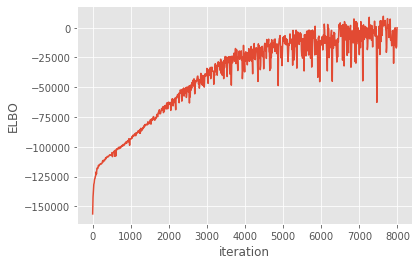

In [46]:
start = time.time()

maxiter = ci_niter(8000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

end = time.time()
print(end - start)

(200, 2)


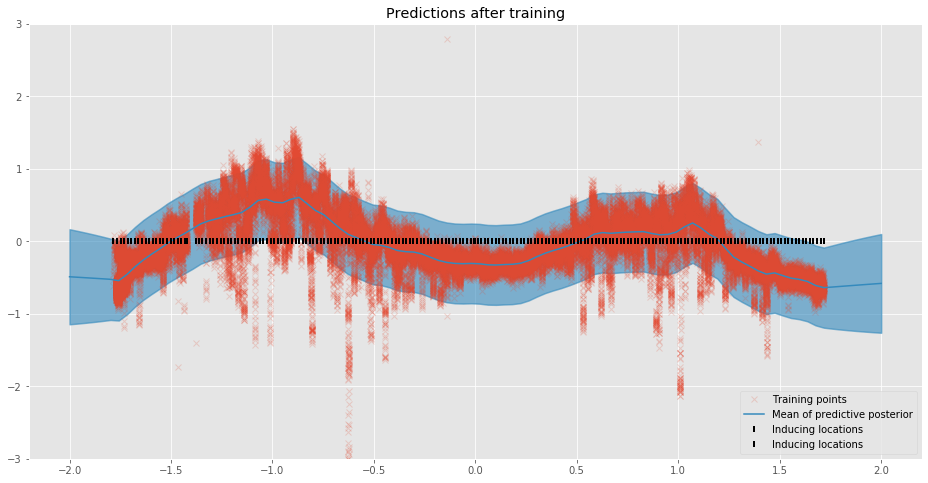

In [47]:
plot("Predictions after training")

In [31]:
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  0.21206182768475623
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  2.814459673458542
SVGP.kernel.kernels[1].variance_a   Parameter  Softplus        True         ()             float64  0.0040021832709675
SVGP.kernel.kernels[1].variance_b   Parameter  Softplus        True         ()             float64  0.003776425682653006
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  0.07494523162966182
SVGP.inducing_variable.Z            Parameter                  False        (200, 2)       float64  [[-1.78378559, 1....
SVGP.q_mu             